In [1]:
!pip install scikit-image
!pip install scikit-learn
!pip install segmentation_models

In [2]:
import os

import keras
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from keras import optimizers, utils
from keras.models import Model

integer_to_class = {
    "1": "meningioma (1)",
    "2": "glioma (2)",
    "3": "pituitary tumor (3)",
}

##Load images, labels, masks
labels = np.load("dataset/labels.npy")
images = np.clip((np.load("dataset/images.npy") / 12728), 0, 1)
masks = np.load("dataset/masks.npy") * 1
print(labels.shape)
print(images.shape)
print(masks.shape)

2022-11-22 06:53:16.400548: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Segmentation Models: using `keras` framework.
(3064,)
(3064, 512, 512)
(3064, 512, 512)


In [3]:
from skimage.transform import resize

img_size_ori = 512
img_size_target = 128


def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(
        img,
        (img_size_target, img_size_target),
        mode="constant",
        preserve_range=True,
    )


def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(
        img, (img_size_ori, img_size_ori), mode="constant", preserve_range=True
    )


images = np.array([downsample(image) for image in images])
masks = (np.array([downsample(mask) for mask in masks]) > 0) * 1

print(images.shape)
print(masks.shape)

(3064, 128, 128)
(3064, 128, 128)


[ 708 1426  930]


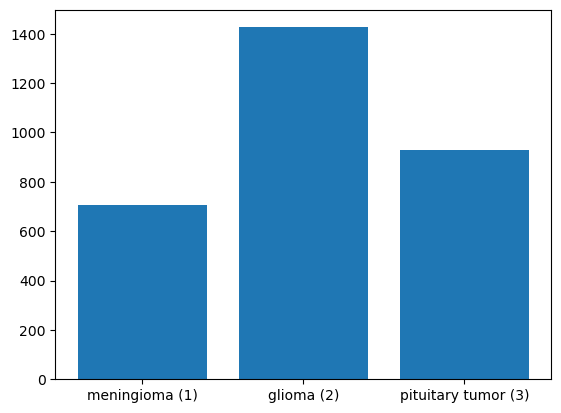

In [4]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, tick_label=list(integer_to_class.values()))
print(counts)

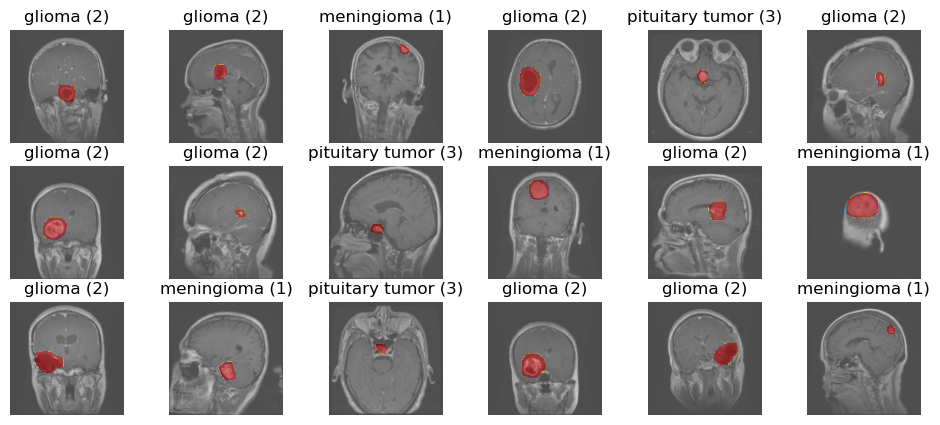

In [5]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap="gray")
    plt.imshow(np.ones_like(masks[idx]) - masks[idx], alpha=0.5, cmap="Set1")
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis("off")

### Train Image and its mask which is to be predicted

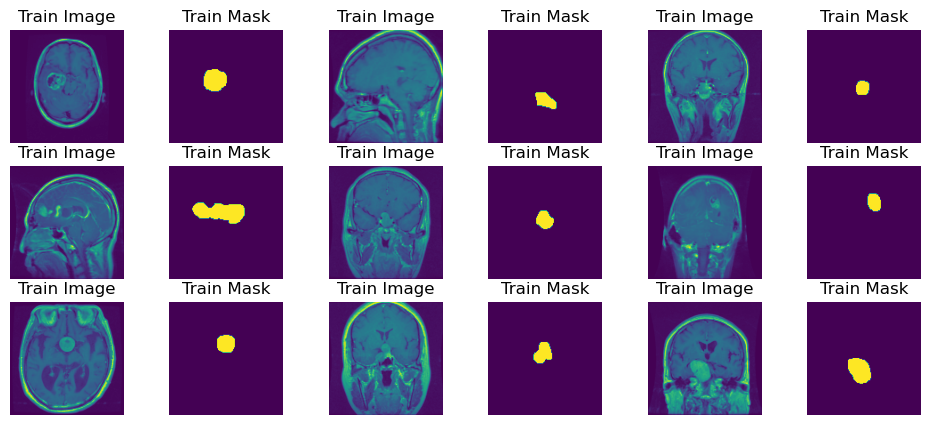

In [6]:
plt.figure(figsize=(12, 5))
i = 1
for idx in np.random.randint(images.shape[0], size=9):
    plt.subplot(3, 6, i)
    i += 1
    plt.imshow(images[idx])
    plt.title("Train Image")
    plt.axis("off")
    plt.subplot(3, 6, i)
    i += 1
    plt.imshow(masks[idx])
    plt.title("Train Mask")
    plt.axis("off")

In [7]:
from keras.utils import normalize

###############################################
# Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
n, h, w = masks.shape
masks_reshaped = masks.reshape(-1, 1)
masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)

np.unique(masks_encoded_original_shape)
masks_input = masks_encoded_original_shape

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
import gc

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    images, masks_input, test_size=0.2, random_state=0
)

x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)

del images
del masks
del labels
gc.collect()
x_train.shape, x_train.shape

((2451, 128, 128, 3), (2451, 128, 128, 3))

### Augmentation

In [9]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(y) for y in y_train], axis=0)
x_train.shape

(4902, 128, 128, 3)

In [10]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)

print(y_train_cat.shape)
print(y_test_cat.shape)

(4902, 128, 128, 3)
(613, 128, 128, 3)


In [11]:
######################################################
# Reused parameters in all models

n_classes = 3
activation = "softmax"
LR = 0.0001

optim = optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [
    "accuracy",
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
]

In [12]:
########################################################################
###Model 1
BACKBONE = "resnet50"
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
x_train = preprocess_input(x_train)
# define model
model = sm.Unet(
    BACKBONE, encoder_weights="imagenet", classes=n_classes, activation=activation
)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

print(model.summary())

2022-11-22 06:54:40.546452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 06:54:40.637625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 06:54:40.638294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 06:54:40.647281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

94592056/94592056 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder

model_checkpoint = ModelCheckpoint(
    "model_best_checkpoint.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1,
)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduceLR = ReduceLROnPlateau(
    patience=4, verbose=2, monitor="val_loss", min_lr=1e-4, mode="min"
)

callback_list = [early_stopping, reduceLR, model_checkpoint]

hist = model.fit(
    x_train,
    y_train_cat,
    batch_size=32,
    epochs=100,
    validation_split=0.25,
    verbose=1,
    callbacks=callback_list,
)

Epoch 1/100


2022-11-22 06:54:54.611413: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-22 06:54:56.881930: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-22 06:54:56.882912: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-22 06:54:56.882951: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-22 06:54:56.883933: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-22 06:54:56.884021: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


115/115 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.8603 - iou_score: 0.3290 - f1-score: 0.3977
Epoch 1: val_loss improved from inf to 0.72819, saving model to model_best_checkpoint.h5
115/115 [==============================] - 48s 292ms/step - loss: 0.7103 - accuracy: 0.8603 - iou_score: 0.3290 - f1-score: 0.3977 - val_loss: 0.7282 - val_accuracy: 0.9749 - val_iou_score: 0.6577 - val_f1-score: 0.6621 - lr: 1.0000e-04
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.5669 - accuracy: 0.9775 - iou_score: 0.4924 - f1-score: 0.5511
Epoch 2: val_loss improved from 0.72819 to 0.68763, saving model to model_best_checkpoint.h5
115/115 [==============================] - 28s 243ms/step - loss: 0.5669 - accuracy: 0.9775 - iou_score: 0.4924 - f1-score: 0.5511 - val_loss: 0.6876 - val_accuracy: 0.9749 - val_iou_score: 0.6583 - val_f1-score: 0.6625 - lr: 1.0000e-04
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.4849 - accu

In [14]:
from keras.models import load_model
model = load_model('model_best_checkpoint.h5', compile=False) #or compile = False

### Plot graph of Dice Loss, IoU Metric, and Dice Coefficient

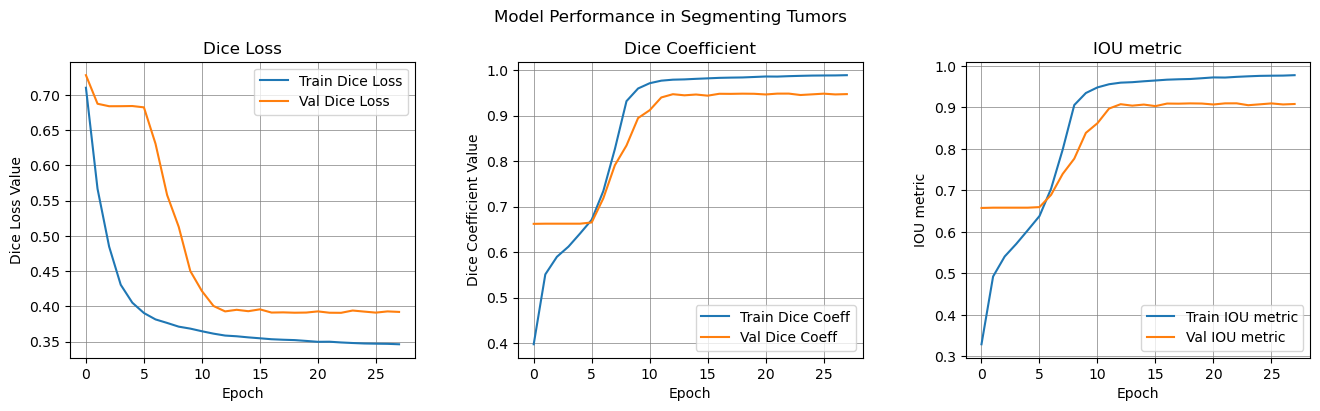

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Model Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['loss'], label='Train Dice Loss')
ax1.plot(epoch_list, hist.history['val_loss'], label='Val Dice Loss')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Dice Loss Value');ax1.set_xlabel('Epoch');ax1.set_title('Dice Loss')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['f1-score'], label='Train Dice Coeff')
ax2.plot(epoch_list, hist.history['val_f1-score'], label='Val Dice Coeff')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Dice Coefficient Value');ax2.set_xlabel('Epoch');ax2.set_title('Dice Coefficient')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['iou_score'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_score'], label='Val IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

### Determine IoU and Dice Coefficient for Threshold=0.5

In [16]:
def iou_metric(label, pred):
    return tf.numpy_function(get_iou_vector, [label, pred>THRESHOLD], tf.float64)

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def get_iou_vector(A, B):
    t = A > 0
    p = B > 0
    intersection = np.logical_and(t, p)
    union = np.logical_or(t, p)
    iou = (np.sum(intersection) + 1e-10) / (np.sum(union) + 1e-10)
    return iou

def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

In [17]:
x_test_pred = np.repeat(x_test[..., np.newaxis], 3, axis=-1)
x_test_pred = preprocess_input(x_test_pred)
import tensorflow as tf
from keras import backend as K
THRESHOLD = 0.5
pred_mask = model.predict(x_test_pred)
iou_score = iou_metric(y_test_cat, pred_mask)
dice_coeff = dice_coefficient(y_test_cat, pred_mask)
print("IoU score is: ", tf.get_static_value(iou_score))
print("Dice Coefficient is: ", tf.get_static_value(dice_coeff))

20/20 [==============================] - 3s 99ms/step
IoU score is:  0.9863174506892153
Dice Coefficient is:  0.9924095


### Predict Masks

In [18]:
x_test.shape

(613, 128, 128)

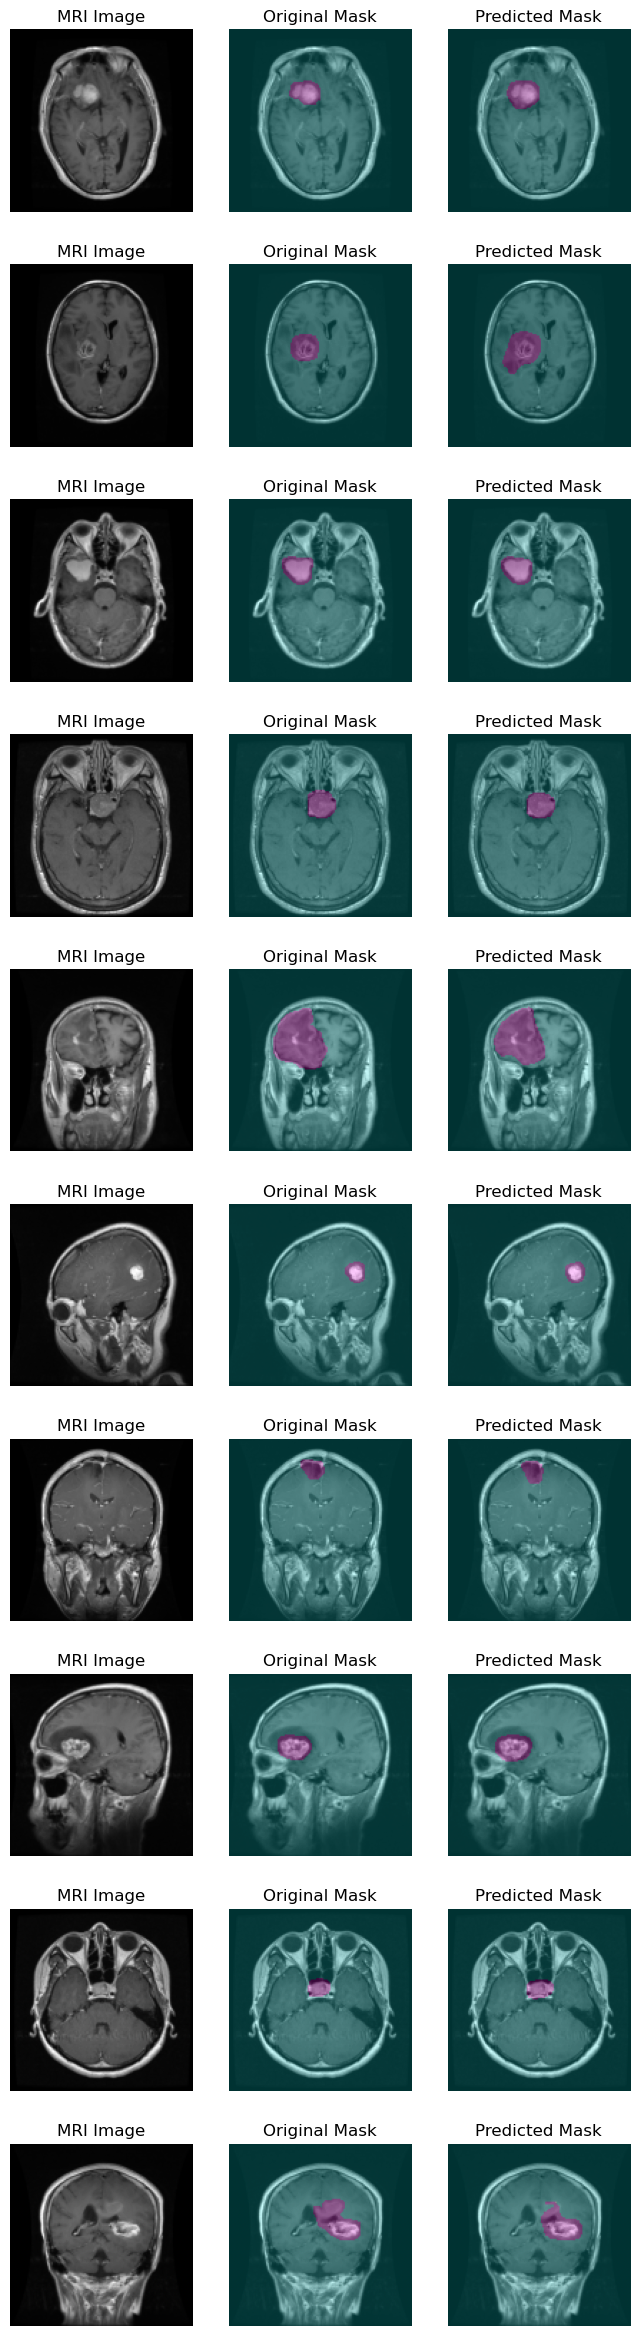

In [19]:
predicted_mask = pred_mask>THRESHOLD * 1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( y_test_cat[0] )
for idx in np.random.randint(0,high=x_test.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - y_test_cat[idx], alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - predicted_mask[idx],  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')

### Plot IoU Curve using different Thresholds

154/154 [==============================] - 9s 60ms/step


Text(0.5, 1.0, 'Threshold vs IoU (0.4545, 0.9935)')

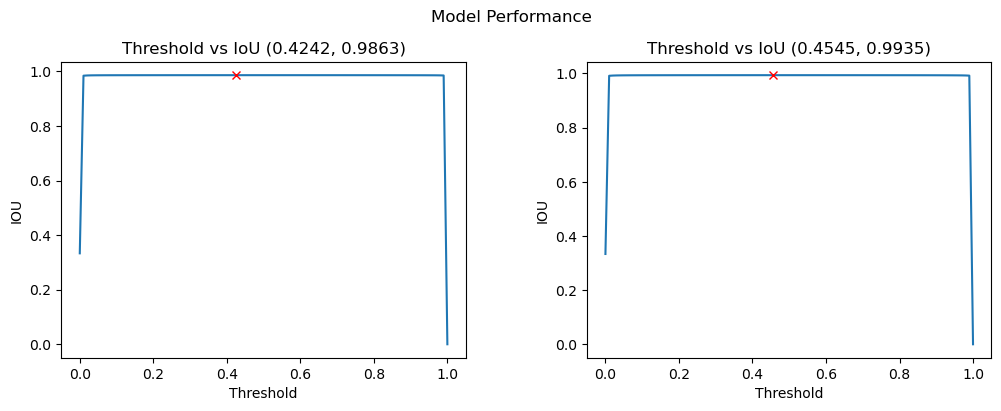

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(y_test_cat,model.predict(x_test_pred))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(round(th_best, 4), round(iou_best, 4)))

th, ious, iou_best, th_best = getIOUCurve(y_train_cat,model.predict(x_train))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax2.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(round(th_best, 4), round(iou_best, 4)))